In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
dataset = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                    test.loc[:, 'MSSubClass':'SaleCondition']))

# Data preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10de7c780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e524208>]], dtype=object)

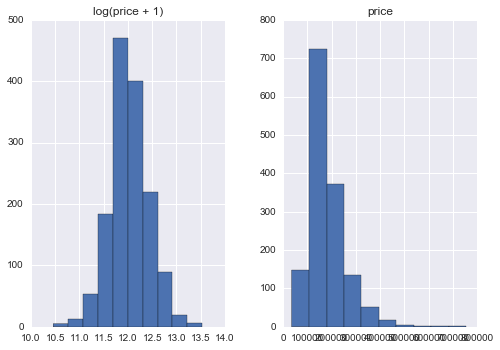

In [4]:
prices = pd.DataFrame({'price': train.SalePrice, 'log(price + 1)': np.log1p(train.SalePrice)})
prices.hist()

In [5]:
train.SalePrice = np.log1p(train.SalePrice)

In [6]:
numeric_features = dataset.dtypes[dataset.dtypes != 'object'].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75].index
skewed_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [7]:
dataset[skewed_features] = np.log1p(dataset[skewed_features])

In [8]:
dataset = pd.get_dummies(dataset)
dataset = dataset.fillna(dataset.mean())

In [9]:
X_train = dataset[:train.shape[0]]
X_test = dataset[train.shape[0]:]
y = train.SalePrice

# Models

In [10]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [11]:
alphas = [0.05, 0.1, 0.3, 1, 3, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

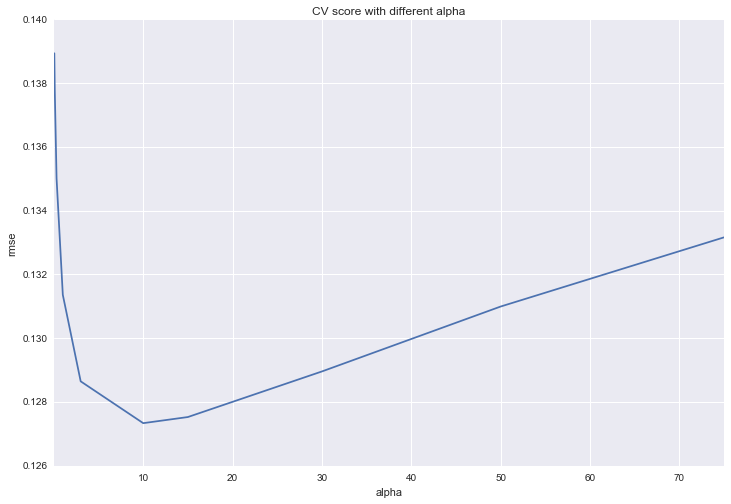

In [12]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='CV score with different alpha', figsize=(12, 8))
plt.xlabel('alpha')
plt.ylabel('rmse')

In [13]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [14]:
rmse_cv(lasso).mean()

0.12314421090977448

In [15]:
coef = pd.Series(lasso.coef_, index=X_train.columns)

In [16]:
print('Lasso picked {} variables and eliminated the other {} variables'.format(
      sum(coef != 0), sum(coef == 0)))

Lasso picked 111 variables and eliminated the other 177 variables


In [17]:
important_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

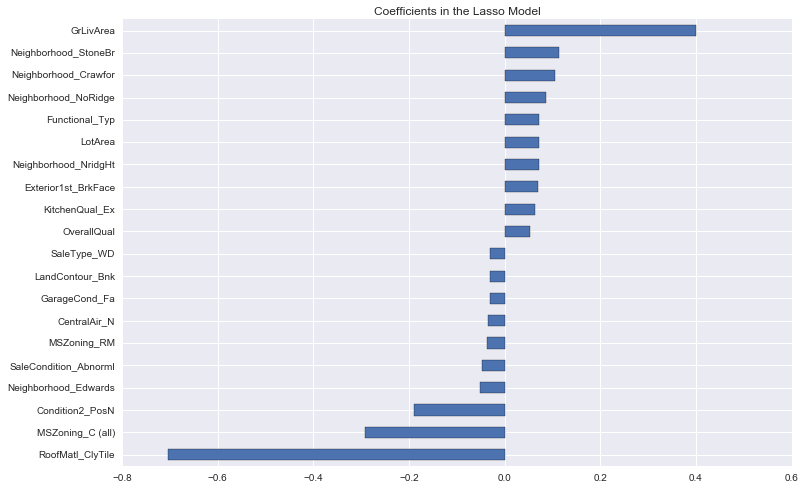

In [18]:
plt.figure(figsize=(12, 8))
important_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

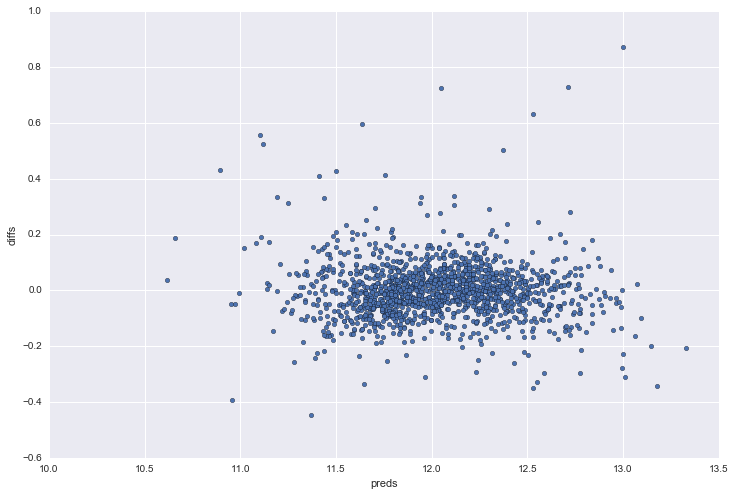

In [19]:
preds = pd.DataFrame({'preds': lasso.predict(X_train), 'true': y})
preds['diffs'] = preds.preds - preds.true
preds.plot(x='preds', y='diffs', kind='scatter', figsize=(12, 8))

In [20]:
class Regressor:
    def __init__(self):
        self.regs = []
        reg = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3,
                                        max_features='sqrt',min_samples_leaf=15,
                                        min_samples_split=10, loss='huber')
        self.regs.append(reg)
        reg = Ridge(alpha=10)
        self.regs.append(reg)
        reg = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
        self.regs.append(reg)
        
    def fit(self, X, y):
        for reg in self.regs:
            reg.fit(X, y)
    
    def predict(self, X):
        h = []
        for reg in self.regs:
            h.append(reg.predict(X))
        df = pd.DataFrame({'SalePrice_{}'.format(idx): pre for idx, pre in enumerate(h)})
        return df

In [21]:
regressor = Regressor()
regressor.fit(X_train, y)
h = regressor.predict(X_test)

In [22]:
h['avg'] = h.mean(axis=1)
h.head(10)

,SalePrice_0,SalePrice_1,SalePrice_2,avg
0,11.701465,11.687132,11.694906,11.694501
1,11.976582,11.938427,11.928232,11.947747
2,12.166274,12.106320,12.101833,12.124809
3,12.219932,12.195477,12.193578,12.202996
4,12.159953,12.207617,12.218175,12.195248
5,12.059961,12.025048,12.046812,12.043940
6,12.030243,12.091022,12.099558,12.073608
7,12.037043,11.988769,11.981599,12.002470
8,12.021474,12.153750,12.186508,12.120577
9,11.766685,11.709464,11.685613,11.720587


In [23]:
ans = pd.DataFrame({'ID': test.Id, 'SalePrice': np.expm1(h['avg'])})

ans.to_csv('data/submit.csv', index=False, float_format='%.4f')